# Marketing Mix Model Demo

This notebook contains a simple implementation of a Marketing Mix Model (MMM) which applies Ad-Stock, Diminishing Return, and Lag transformations to each input feature in the training dataset.

To run the workbook, enter the following information in the **2) Parameters and Dataset** section of the notebook:

- **Cell 12**: Desired folder- and file-name corresponding to the user's chosen dataset
- **Cell 15**: Update the index-, feature-, and target-name lists
- **Cell 17**: Appropriate range and value count figures in the transformation_parameters dictionary
- **Cell 19**: Specify your chosen test_size fraction (a value between 0 and 1 representing the percent of records to be withheld for the test set)

After that, select Run All Cells and view your estimated Marketing contributions!

#### 0) Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
from scipy.ndimage.interpolation import shift
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
import itertools
import warnings

#### 1) Functions

In [2]:
def plot_hist(df: pd.DataFrame(),
              bins: int) -> None:
    """
    The plot_hist() function takes a dataframe and plots histograms for each feature according to the number of bins specified 
    in input.
    """
    feature_names = df.columns
    for feature_name in feature_names:
        print(feature_name)
        feature_df[feature_name].plot.hist(bins=bins, figsize=(4,2))
        pl.show()

In [3]:
def plot_corr_vals(df: pd.DataFrame()) -> None:
    """
    The plot_corr_vals() function will create a correlation plot for the features in the input dataframe.
    """
    f, ax = pl.subplots(figsize=(3,3))
    corr = df.corr()
    sns.heatmap(corr,
                cmap=sns.light_palette("seagreen", as_cmap=True))

In [4]:
def transform_activity_values(activity_values: list,
                              transformation_type: str,
                              transformation_parameters: list) -> np.array(0):
    """
    The transform_activity_values() function takes a list of activity values and applies the transformation specified in input.
    There are 3 types of transformations available:
    
    Ad-stock:
        - Takes a decimal value between 0 and 1 which corresponds to the amount of residual activity which carries over into 
          subsequent time-steps.
          
    Diminishing Returns:
        - Applies an exponential transformation of the form X^A, where A is the exponent parameter specified as an input to
          the function.
          
    Time Lag:
        - Returns the value stored in the record N time steps prior to the record being evaluated.  This value is an integer, 
          and will shift the array by the number of time units specified as an input.
    """
    if transformation_type == 'adstock':
        adstock = transformation_parameters[0]
        transformed_activity_values = []
        previous_transformed_activity_value = None
        
        for value in activity_values:
            if len(transformed_activity_values) == 0:
                # For the first iteration, the first transformed activity value will just be the first value.  Additionally, we
                # assign the first value to be the previous_transformed_activity_value for the second step.
                transformed_activity_values.append(value)
                previous_transformed_activity_value = value
                
            else:
                # Apply the ad-stock decay to the previous transformed activity value, and then add it to the current step's 
                # activity value.  Then store the transformed value for the subsequent time step.
                transformed_actvity_value = value+(adstock*previous_transformed_activity_value)
                transformed_activity_values.append(transformed_actvity_value)
                previous_transformed_activity_value = transformed_actvity_value

    elif transformation_type == 'dim_return':
        exponent = transformation_parameters[0]
        # Raise all values to the specified exponential power
        transformed_activity_values = np.power(activity_values, exponent)

    elif transformation_type == 'lag':
        lag = transformation_parameters[0]
        # Shift entire array by specified number of time-steps
        transformed_activity_values = shift(activity_values, lag, cval=np.NaN)

    else:
        raise ValueError('Please use one of the accepted transformation types.')

    return transformed_activity_values

In [5]:
def append_transformed_activity_values(feature_df: pd.DataFrame(),
                                       input_feature_name: str,
                                       transformation_types: list,
                                       transformation_parameters: tuple) -> pd.DataFrame():
    """
    The append_trandformed_activity_values() function calls the transform_activity_values() function and transforms the 
    specified activity feature to the transformation types specified in input.  Then, it appends the transformed values
    and names the column with the prefix 'transformed_'.
    
    The transformation types available are as follows:
    
    Ad-stock:
        - Takes a decimal value between 0 and 1 which corresponds to the amount of residual activity which carries over into 
          subsequent time-steps.
          
    Diminishing Returns:
        - Applies an exponential transformation of the form X^A, where A is the exponent parameter specified as an input to
          the function.
          
    Time Lag:
        - Returns the value stored in the record N time steps prior to the record being evaluated.  This value is an integer, 
          and will shift the array by the number of time units specified as an input.
          
    Parameters:
        - feature_df: a pandas dataframe which contains activity values for the base activity features
        - input_feature_name: the name of the feature from feature_df which is to be transformed
        - transformation_types: a list of transformations to be applied to the feature.  For example, if a feature is to be
            ad-stock and diminishing-return transformed, transformation_types = ['adstock','dim_return']
        - transformation_parameters: a list of parameter values to be passed to the transform_activity_values() function.  The
            first parameter always corresponds to Ad-stock, the second to Diminishing Returns, and the third to Lag.
    """
    transformed_activity_values = feature_df[input_feature_name]
    adstock_parameters = [transformation_parameters[0]]
    dim_return_parameters = [transformation_parameters[1]]
    lag_parameters = [transformation_parameters[2]]
    
    if 'adstock' in transformation_types:
        transformed_activity_values = transform_activity_values(activity_values=transformed_activity_values,
                                                                transformation_type='adstock',
                                                                transformation_parameters=adstock_parameters)
    if 'dim_return' in transformation_types:
        transformed_activity_values = transform_activity_values(activity_values=transformed_activity_values,
                                                                transformation_type='dim_return',
                                                                transformation_parameters=dim_return_parameters)
    if 'lag' in transformation_types:
        transformed_activity_values = transform_activity_values(activity_values=transformed_activity_values,
                                                                transformation_type='lag',
                                                                transformation_parameters=lag_parameters)

    transformed_feature_name = 'transformed_'+input_feature_name
    transformed_feature_df = pd.DataFrame({transformed_feature_name:transformed_activity_values})
    
    return_df = pd.concat([feature_df, transformed_feature_df], axis=1)
    return return_df

In [6]:
def generate_parameter_combinations(parameters: dict) -> list:
    """
    The generate_parameter_combinations() function takes as input a dictionary where each key corrsponds to a transformation, 
    and each value corresponds to the range of parameter values to be tested for each transformation.  An example is provided 
    below for Ad-stock and DIminishing Return transformations where 3 values between 0.5 and 1 are tested:
    
    Ex:
        - parameters = {'adstock':[0.50,0.75,1.00],
                        'dim_return':[0.50,0.75,1.00]}
    """
    transformations = parameters.keys()
    parameter_value_lists = [parameters[transformation] for transformation in transformations]

    parameter_combinations = list(itertools.product(*parameter_value_lists))
    return parameter_combinations 

In [7]:
def create_datasets(feature_df: pd.DataFrame(), 
                    target_df: pd.DataFrame(), 
                    test_size: float) -> pd.DataFrame():
    """
    The create_datasets() function takes a feature- and target-dataframe as input, in addition to a decimal test-size fraction
    between 0 and 1, and returns training and test feature and target datasets.
    """
    train_test_split_index = round(feature_df.shape[0]*(1-test_size))
    
    X_train, X_test = feature_df.iloc[0:train_test_split_index], feature_df.iloc[train_test_split_index::]
    y_train, y_test = target_df.iloc[0:train_test_split_index], target_df.iloc[train_test_split_index::]
    
    return X_train, X_test, y_train, y_test

In [8]:
def optimize_feature_parameters(input_feature_name: str,
                                transformation_types: list,
                                feature_parameter_combinations: list,
                                feature_df: pd.DataFrame()) -> tuple:
    """
    The optimize_feature_parameters() takes a list of transformation parameters and tests the specified feature for an 
    optimal configuration.  It iterates through each parameter combination, fits a model for each, and returns the combination
    which produced the lowest root-mean-squared error (RMSE) (as well as the RMSE that was produced).
    """
    feature_names = feature_df.columns
    
    # Initialize variables for best RMSE results
    best_rmse = None
    best_parameter_combination = None
    
    for parameter_combination in feature_parameter_combinations:
        # Calculate the record number at which lag-transformed records will be non-null
        lag_drop_index = parameter_combination[2]
        
        # Transform the dataframe according to the specified transformation list, and drop the non-transformed features to
        # ensure that parameters are seletced only for the transformed features' effect on the target prediction
        transformed_feature_df = append_transformed_activity_values(feature_df=feature_df,
                                                                    input_feature_name=input_feature_name,
                                                                    transformation_types=transformation_types,
                                                                    transformation_parameters=parameter_combination)
        transformed_feature_df.drop(columns=feature_names, inplace=True)
        
        # Create train/test splits and drop null lag-transformed records
        X_train, X_test, y_train, y_test = create_datasets(feature_df=transformed_feature_df, 
                                                           target_df=target_df, 
                                                           test_size=test_size)
        X_train, y_train = X_train.iloc[lag_drop_index::], y_train.iloc[lag_drop_index::]
        
        # Fit the model and calculate error metrics
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        if best_rmse is None:
            best_rmse = rmse
            best_parameter_combination = parameter_combination
        elif rmse < best_rmse:
            best_rmse = rmse
            best_parameter_combination = parameter_combination
            
    return (best_parameter_combination, best_rmse)

In [9]:
def get_optimal_feature_parameters(input_feature_parameter_grid: dict,
                                   feature_df: pd.DataFrame()) -> dict:
    """
    The get_optimal_feature_parameters() function takes the user-generated input_feature_parameter_grid dictionary and feature
    data frame as input, and returns optimal transformation parameters for each feature.  
    
    As an example, the input_feature_parameter_grid that corresponds to Ad-Stock and Lag transformations, with respective
    parameter lists of [0.7,0.9] and [5,10], on only the 'tv' feature is structured as follows:
    
    input_feature_parameter_grid = {'tv':(['adstock','lag'], [(0.7,5),(0.7,10),(0.9,5),(0.9,10)])}
    """
    # Initialize the return dictionary
    optimized_parameter_dict = {}
    
    # Create a list of feature names to iterate through
    input_feature_names = [input_feature_name for input_feature_name in input_feature_parameter_grid.keys()]
    for input_feature_name in input_feature_names:
        # Store transformation types and possible parameter configurations, and then identify optimal parameters
        transformation_types = input_feature_parameter_grid[input_feature_name][0]
        input_feature_parameter_combinations = input_feature_parameter_grid[input_feature_name][1]
        input_feature_parameter_configuration = optimize_feature_parameters(input_feature_name=input_feature_name,
                                                                            transformation_types=transformation_types,
                                                                            feature_parameter_combinations=input_feature_parameter_combinations,
                                                                            feature_df=feature_df,
                                                                            )
        
        # Store optimal parameters in the return dictionary
        optimized_parameter_dict[input_feature_name] = input_feature_parameter_configuration
    
    return optimized_parameter_dict

In [10]:
def generate_optimized_training_dataset(feature_df: pd.DataFrame(),
                                        target_df: pd.DataFrame(),
                                        feature_names: list,
                                        transformation_names: list,
                                        optimal_feature_parameters: dict) -> pd.DataFrame():
    """
    The generate_optimized_training_dataset() function will take the names of the features to be transformed, and their 
    corresponding optimal parameters, and returns transformed training/test dataset.
    """
    # Create an adjusted optimal parameter dictionary which removes the RMSE associated with the feature's transformation
    optimal_feature_parameters_adj = {}
    for feature_name in feature_names:
        optimal_feature_parameters_adj[feature_name] = optimal_feature_parameters[feature_name][0]
        
    first_feature = True
    optimized_df = None
    for feature_name in feature_names:
        # If iterating through the first feature, make record of that and transform feature_df first
        if first_feature:
            first_feature = False
            transformation_parameters = optimal_feature_parameters_adj[feature_name]
            optimized_df = append_transformed_activity_values(feature_df=feature_df,
                                                              input_feature_name=feature_name,
                                                              transformation_types=transformation_names,
                                                              transformation_parameters=transformation_parameters)
        
        # If it is not the first feature, continue to transform optimized_df
        else:
            transformation_parameters = optimal_feature_parameters_adj[feature_name]
            optimized_df = append_transformed_activity_values(feature_df=optimized_df,
                                                              input_feature_name=feature_name,
                                                              transformation_types=transformation_names,
                                                              transformation_parameters=transformation_parameters)
            
    # Initialize a null-value counter and iterate through each column to identify a maximum-null record
    max_null_count = 0
    for feature in optimized_df.columns:
        null_count = optimized_df[feature].isna().sum()
        if null_count > max_null_count:
            max_null_count = null_count
            
    # Drop the non-transformed feature columns
    optimized_df.drop(columns=feature_names, inplace=True)
            
    # Drop the number of records from the beginning of the dataframe corresponding to the maximum null count
    optimized_feature_df, optimized_target_df = optimized_df.iloc[max_null_count::], target_df.iloc[max_null_count::]
    
    return optimized_feature_df, optimized_target_df

In [11]:
def fit_model(model: object,
              X_train: pd.DataFrame(),
              y_train: pd.DataFrame(),
              X_test: pd.DataFrame(),
              y_test: pd.DataFrame()) -> object:
    """
    The fit_model() function will take the specified model object and train/test dataframes as input, fit the model passed to
    it, and return the fit model as an output.  Additionally, it will print the associated test results.
    """
    # Filter warnings for the statsmodels API
    warnings.filterwarnings('ignore')
    
    target_name = y_train.columns[0]
    # Fit the model passed in input
    model.fit(X_train, y_train)
    
    # Calculate error metrics
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Create the results dataframe
    y_pred = pd.DataFrame(y_pred, index=list(y_test.index)).rename(columns={0:target_name+'_pred'})
    result_df = pd.concat([y_test, y_pred], axis=1)
    
    # Plot the results
    result_df.plot()
    pl.show()
    
    # Fit an OLS and report P-values for each feature
    X_train_constant = sm.add_constant(X_train)
    ols = sm.OLS(y_train, X_train_constant)
    ols_fit = ols.fit()
    print(ols_fit.summary())
    
    return model

#### 2) Parameters and Data Load

In [12]:
folder = 'C:\\Users\\rbush\\Documents\\MMM'
filename = 'MMM Dataset 2.csv'

In [13]:
df = pd.read_csv(folder+'\\'+filename).dropna()

In [14]:
df.head()

,Date,TV,Radio,Banners,Sales
0,1/7/2018,13528.1,0.00,0.00,9779.80
1,1/14/2018,0.0,5349.65,2218.93,13245.19
2,1/21/2018,0.0,4235.86,2046.96,12022.66
3,1/28/2018,0.0,3562.21,0.00,8846.95
4,2/4/2018,0.0,0.00,2187.29,9797.07


In [15]:
index_names = ['Date']
feature_names = ['TV','Radio','Banners']
target_names = ['Sales']

In [16]:
index_df = df[index_names]
feature_df = df[feature_names]
target_df = df[target_names]

In [17]:
adstock_parameter_range = np.linspace(0.1,0.9,9)
dim_return_parameter_range = np.linspace(0.2,1,5)
lag_parameter_range = np.linspace(0,20,6)

In [18]:
transformation_parameters = {'adstock':[round(parameter,1) for parameter in adstock_parameter_range],
                             'dim_return':[round(parameter,1) for parameter in dim_return_parameter_range],
                             'lag':[int(parameter) for parameter in lag_parameter_range]}
transformation_names = [transformation_name for transformation_name in transformation_parameters.keys()]

In [19]:
test_size = 0.2

#### 3) EDA

TV


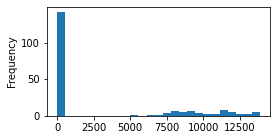

Radio


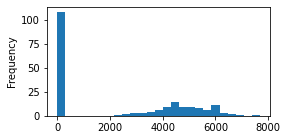

Banners


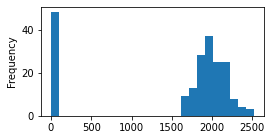

In [20]:
plot_hist(feature_df, bins=25)

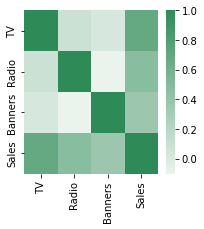

In [21]:
plot_corr_vals(pd.concat([feature_df, target_df], axis=1))

#### 4) Baseline Linear Model

In [22]:
X_train, X_test, y_train, y_test = create_datasets(feature_df=feature_df, 
                                                   target_df=target_df, 
                                                   test_size=test_size)

In [23]:
lr = LinearRegression()

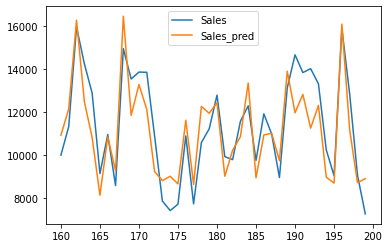

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     191.2
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           4.92e-52
Time:                        17:46:19   Log-Likelihood:                -1369.7
No. Observations:                 160   AIC:                             2747.
Df Residuals:                     156   BIC:                             2760.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6650.9970    224.522     29.623      0.0

In [24]:
lr = fit_model(model=lr,
               X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test)

#### 5) Optimal Transformation Parameters

In [25]:
parameter_configurations = generate_parameter_combinations(parameters=transformation_parameters)

In [26]:
input_feature_parameter_grid = {}
for feature_name in feature_names:
    input_feature_parameter_grid[feature_name] = (transformation_names, parameter_configurations)

In [27]:
optimal_feature_parameters = get_optimal_feature_parameters(input_feature_parameter_grid=input_feature_parameter_grid,
                                                            feature_df=feature_df)

In [28]:
optimal_feature_parameters

{'TV': ((0.4, 0.8, 0), 1735.2923934486782),
 'Radio': ((0.5, 1.0, 0), 2412.947910874101),
 'Banners': ((0.2, 1.0, 0), 2269.5954377365406)}

#### 6) Optimized Model Results

In [29]:
optimized_feature_df, optimized_target_df = generate_optimized_training_dataset(feature_df=feature_df,
                                                                                target_df=target_df,
                                                                                feature_names=feature_names,
                                                                                transformation_names=transformation_names,
                                                                                optimal_feature_parameters=optimal_feature_parameters)

In [30]:
X_train, X_test, y_train, y_test = create_datasets(feature_df=optimized_feature_df, 
                                                   target_df=optimized_target_df, 
                                                   test_size=test_size)

In [31]:
lr = LinearRegression()

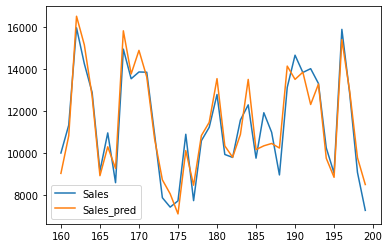

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     742.6
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           4.19e-92
Time:                        17:46:25   Log-Likelihood:                -1275.0
No. Observations:                 160   AIC:                             2558.
Df Residuals:                     156   BIC:                             2570.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4434.4389    

In [32]:
lr = fit_model(model=lr,
               X_train=X_train,
               y_train=y_train,
               X_test=X_test,
               y_test=y_test)